<a href="https://colab.research.google.com/github/RevanthBN/Iris-Pupil-Segmentation/blob/main/Iris_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mounting the Google drive and cloning the github repo!**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/Iris-Pupil-Segmentation/
!git pull

Mounted at /content/gdrive
/content/gdrive/My Drive/Iris-Pupil-Segmentation
Already up to date.


In [2]:
!pip install segmentation-models-pytorch

     |████████████████████████████████| 87 kB 3.2 MB/s 
     |████████████████████████████████| 58 kB 7.4 MB/s 
     |████████████████████████████████| 376 kB 23.3 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=f37f8d61dec036b534bf813eac30ec74100a85ccfd859e9e4564c789a2fb27c0
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=c780a3433d3926af11ad8fe6ca26c9acb47b8734b536d3387f1ee31187df7ec6
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


**Import all you want!**

In [3]:
# Global libraries
import os
from glob import glob

# Python libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import torch.nn.functional as F
import math

# Image processing
import cv2
from PIL import Image

# Pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, random_split, DataLoader
import segmentation_models_pytorch as smp

# Others
import time
cuda = torch.cuda.is_available()

**Additional global variables**



In [4]:
# Path for the training set
train_images_path = glob('training_set/images/*')
train_groundtruth_path = glob('training_set/groundtruths/*')
train_masks_path = glob('training_set/masks/*')

# Path for the test set
test_images_path = glob('testing_set/images/*')
test_groundtruth_path = glob('testing_set/groundtruths/*')
test_masks_path = glob('testing_set/masks/*')

# Image sizes for resizing
width = 256
height = 256
dim = (width, height)

**Hyperparameters to be tuned**

In [5]:
# Percentage for the train-val split
val_percent = 0.3

# Number of workers for dataloader
num_workers = 4 if cuda else 0 

# Batch size during training
batch_size = 20

# Number of training epochs
num_epochs = 30

# Learning rate for optimizers
lr = 1e-2

# Checkpoint path
checkpoint_path = "files/checkpoint.pth"


**Loading the dataset from the cloned drive folder**

In [6]:
class Iris(Dataset):
    def __init__(self, images_path, masks_path):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        # Reading image 
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
        image = image/255.0 ## (256, 256, 3)
        image = np.transpose(image, (2, 0, 1))  ## (3, 256, 256)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        # Reading mask 
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, dim, interpolation = cv2.INTER_AREA)
        mask = mask/255.0   ## (256, 256)
        mask = np.expand_dims(mask, axis=0) ## (256, 256)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples

**Creating the datasets**

In [7]:
# Creating the datasets 
train_dataset = Iris(train_images_path, train_masks_path)
test_set = Iris(test_images_path, test_masks_path)

**Splitting the train dataset into Training and Validation sets by a 70-30 split with a manual seed of 0**

In [8]:
n_val = int(len(train_dataset) * val_percent)
n_train = len(train_dataset) - n_val
train_set, val_set = random_split(train_dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

data_str = f"Dataset Size:\nTrain: {len(train_set)} - Validation: {len(val_set)} - Test: {len(test_set)}\n"
print(data_str)

Dataset Size:
Train: 379 - Validation: 162 - Test: 10



**Loading the dataloader for the datasets**

In [9]:
# Training data
train_loader_args = dict(shuffle=True, batch_size=batch_size, num_workers=num_workers) if cuda\
                    else dict(shuffle=True, batch_size=batch_size)
train_loader = DataLoader(train_set, **train_loader_args)

# Validation data
val_loader_args = dict(shuffle=True, batch_size=batch_size, num_workers=num_workers) if cuda\
                    else dict(shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_set, **val_loader_args)

# Testing data
test_loader_args = dict(shuffle=False, num_workers=num_workers) if cuda\
                    else dict(shuffle=False,drop_last=True)
test_loader = DataLoader(test_set, **test_loader_args)


**Dice Loss Function** 

In [10]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE


**Model definition**

In [11]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs


In [12]:
device = torch.device("cuda" if cuda else "cpu")
model = build_unet()
# model = smp.Unet('resnet34', encoder_weights="imagenet", classes=3, activation='softmax')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()
model = model.to(device)

**Utility Functions**

In [13]:
# Calculate the time taken 
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

**Training and Validation Functions**

In [14]:
def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0
    print("Entered Training")
    model.train()
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0
    print("Entered Evaluation")
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss/len(loader)
    return epoch_loss

**Training and Evaluation of the model**

In [16]:
best_valid_loss = float("inf")

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, loss_fn, device)
    valid_loss = evaluate(model, val_loader, loss_fn, device)

    # Saving the model
    if valid_loss < best_valid_loss:
        data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
        print(data_str)

        best_valid_loss = valid_loss
        torch.save(model.state_dict(), checkpoint_path)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
    data_str += f'\tTrain Loss: {train_loss:.3f}\n'
    data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
    print(data_str)

Entered Training


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Entered Evaluation
Valid loss improved from inf to 1.6176. Saving checkpoint: files/checkpoint.pth
Epoch: 01 | Epoch Time: 3m 23s
	Train Loss: 0.204
	 Val. Loss: 1.618

Entered Training
Entered Evaluation
Valid loss improved from 1.6176 to 0.1521. Saving checkpoint: files/checkpoint.pth
Epoch: 02 | Epoch Time: 0m 14s
	Train Loss: 0.143
	 Val. Loss: 0.152

Entered Training
Entered Evaluation
Valid loss improved from 0.1521 to 0.1385. Saving checkpoint: files/checkpoint.pth
Epoch: 03 | Epoch Time: 0m 13s
	Train Loss: 0.129
	 Val. Loss: 0.139

Entered Training
Entered Evaluation
Valid loss improved from 0.1385 to 0.1322. Saving checkpoint: files/checkpoint.pth
Epoch: 04 | Epoch Time: 0m 13s
	Train Loss: 0.121
	 Val. Loss: 0.132

Entered Training
Entered Evaluation
Valid loss improved from 0.1322 to 0.1194. Saving checkpoint: files/checkpoint.pth
Epoch: 05 | Epoch Time: 0m 14s
	Train Loss: 0.119
	 Val. Loss: 0.119

Entered Training
Entered Evaluation
Epoch: 06 | Epoch Time: 0m 13s
	Train L

(160, 224, 3)


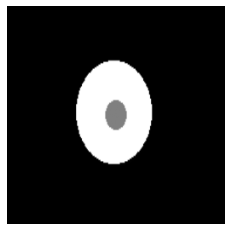

In [16]:
gg = 'training_set/masks/000008372_Ycrop_Hres_L.png'
image = cv2.imread(gg, cv2.IMREAD_COLOR)
print(image.shape)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, dim)
image = image/255.0 ## (256, 256, 3)
plt.imshow(image);
plt.axis("off");
# image = np.transpose(image, (2, 0, 1))  ## (3, 256, 256)
# image = image.astype(np.float32)
# image = torch.from_numpy(image)

In [17]:
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

build_unet(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2

In [18]:
checkpoint = torch.load(checkpoint_path)

In [19]:
def predict(model, loader, loss_fn, device):
    epoch_loss = 0
    y_preds = []
    print("Entered Evaluation")
    with torch.no_grad():
        model.eval()
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

            y_preds.append(y_pred)
        epoch_loss = epoch_loss/len(loader)
    return epoch_loss, y_preds


In [20]:
test_loss, pred_masks = predict(model, test_loader, loss_fn, device)

Entered Evaluation


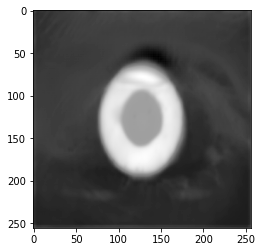

In [21]:
pred_m = pred_masks[1].cpu()
pred_m=np.squeeze(pred_m, axis=0)  
pred_m=np.squeeze(pred_m, axis=0)  
pred_m=pred_m*255
plt.imshow(pred_m, cmap = 'gray');

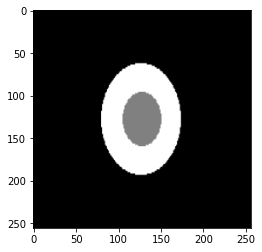

In [22]:
test_image = test_set[1][1].cpu().numpy()
test_image = np.squeeze(test_image, axis=0) 
test_image = test_image*255
plt.imshow(test_image, cmap = 'gray'); 

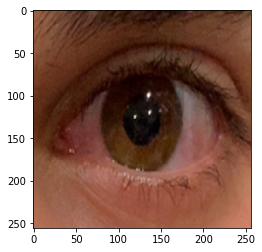

In [23]:
test_image = test_set[1][0].cpu().numpy()
test_image = np.squeeze(test_image) 
test_image = np.transpose(test_image, (1, 2, 0)) 
plt.imshow(test_image); 

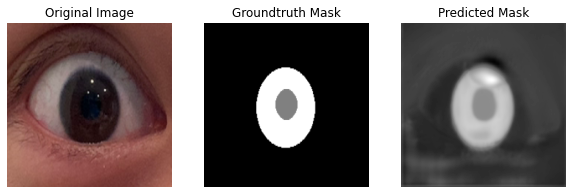

In [35]:
# len(test_set)
for i in range(1):
  # Processing the original image
  test_original = test_set[i][0].cpu().numpy()
  test_original = np.squeeze(test_original) 
  test_original = np.transpose(test_original, (1, 2, 0))

  
  # Processing the groundtruth mask
  line = np.ones((256, 10, 3)) * 128
  test_image = test_set[i][1].cpu().numpy()
  test_image = np.squeeze(test_image, axis=0) 
  test_image = test_image*255

  # Processing the predicted mask
  pred_m = pred_masks[i].cpu().numpy()
  pred_m=np.squeeze(pred_m, axis=0)  
  pred_m=np.squeeze(pred_m, axis=0)  
  pred_m=pred_m*255

  # Visuzalizing the predicted masks and actual masks alongside the original images
  plt.figure(figsize=(10,20))
  plt.subplot(1,3,1)
  plt.imshow(test_original)
  plt.axis("off")
  plt.title("Original Image")
  plt.subplot(1,3,2)
  plt.imshow(test_image, cmap='gray')
  plt.axis("off")
  plt.title("Groundtruth Mask")
  plt.subplot(1,3,3)
  plt.imshow(pred_m, cmap='gray')
  plt.axis("off")
  plt.title("Predicted Mask")

  

In [66]:
print(len(test_set))

10
